# Multi-Scenario MORDM Holistic Approach
This Jupyter Notebook uses the model developed by [Ciullo et al. (2019)](https://scholar.google.com/citations?hl=en&user=fDZCVVYAAAAJ&view_op=list_works&sortby=pubdate#d=gs_md_cita-d&u=%2Fcitations%3Fview_op%3Dview_citation%26hl%3Den%26user%3DfDZCVVYAAAAJ%26sortby%3Dpubdate%26citation_for_view%3DfDZCVVYAAAAJ%3AqjMakFHDy7sC%26tzom%3D-120) and the [ema_workbench by Jan Kwakkel](https://github.com/quaquel/EMAworkbench) to evaluate possible strategies for the Gelderland province to increase its resilience to flood risk. It is specifically aimed towards finding optimal strategies from a holistic point of view, namely decreasing damages and casualties all along the Ijssel River. By conducting this analysis, the province of Gelderland, as well as other actors, are provided with optimal policies which serve a common goal. 

## Imports

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import networkx as nx
import scipy as sp
import plotly.express as px


# Workbench Imports
from ema_workbench import (Model, MultiprocessingEvaluator, ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter, optimize, Scenario, Constant, ema_logging,perform_experiments, SequentialEvaluator, Policy)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator, BaseEvaluator
from ema_workbench.analysis import parcoords, prim


ema_logging.log_to_stderr(ema_logging.INFO)


E:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Logger EMA (DEBUG)>

## General Model Setup
Here, we specify the numbers for the experiment and optimization runs to perform. The reference scenario used to initialise this model is the 10,000 scenarios run on PF1 with the base-case scenario of no action taken. This was used as reference as it outputs the worst-case on the most aggregated level. The outputs for PF1 were total number of deaths, total damage and total dike investment cost.

The problem formulation which will be used throughout this notebook to make calculations and run the model is Problem Formulation 8. This is tailored to the holistic case, as it outputs total number of deaths, evacuation costs, room for the river costs, and gives the dike investment costs and estimated damage per province. These are provided per province as thereby it minimises the damages irrespective of the actor, while showing where the damages would be and investment costs have to be made as to come up with a fair cost distribution.

In [2]:
# Number of nfes for the Model
n_nfe = 20000

#Number of scenarios for the deep uncertainty evaluation of promising scenarios
n_scenarios = 1000

#Path to the reference scenarios to use for MORDM
path_noaction = "../results/10000Scenarios_NoAction_PF1.tar.gz"

## Model Specification

In [3]:
# Model Imports
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(8)
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

## Specify reference scenario
Firstly, we load the results from the open exploration with no action taken to select a reference scenario that shows the most expected number of deaths. This, so-to-say worst-case scenario is then used to find the optimal policies using the MORDM approach.  

In [4]:
experiments, outcomes = load_results(path_noaction)

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\10000Scenarios_NoAction_PF1.tar.gz


In [5]:
outcomes_df = pd.DataFrame(outcomes)

#Get index of worst scenario
index_wc = outcomes_df.sort_values("Expected Number of Deaths").tail(1).index
experiment_wc = experiments.iloc[index_wc]
reference_scenarios = [Scenario(f"{index}", **row) for index, row in experiment_wc.iloc[0:,0:19].iterrows()]

## Run Optimization on Worst Case Reference Scenario

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)

convergence_metrics = [EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_epsilon_0_1 = evaluator.optimize(nfe=n_nfe, epsilons=[0.1,]*len(dike_model.outcomes), 
    reference = reference_scenarios[0], convergence= convergence_metrics, searchover="levers")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/20000 nfe
[MainProcess/INFO] generation 5: 499/20000 nfe
[MainProcess/INFO] generation 10: 999/20000 nfe
[MainProcess/INFO] generation 15: 1499/20000 nfe
[MainProcess/INFO] generation 20: 1997/20000 nfe
[MainProcess/INFO] generation 25: 2494/20000 nfe
[MainProcess/INFO] generation 30: 2991/20000 nfe
[MainProcess/INFO] generation 35: 3489/20000 nfe
[MainProcess/INFO] generation 40: 3988/20000 nfe
[MainProcess/INFO] generation 45: 4486/20000 nfe
[MainProcess/INFO] generation 50: 4984/20000 nfe
[MainProcess/INFO] generation 55: 5483/20000 nfe
[MainProcess/INFO] generation 60: 5982/20000 nfe
[MainProcess/INFO] generation 65: 6479/20000 nfe
[MainProcess/INFO] generation 70: 6976/20000 nfe
[MainProcess/INFO] generation 75: 7473/20000 nfe
[MainProcess/INFO] generation 80: 7973/20000 nfe
[MainProcess/INFO] generation 85: 8469/20000 nfe
[MainProcess/INFO] generation 90: 8964/20000 nfe
[MainProcess/INFO] generation 95: 9461/20000

In [7]:
results, convergence = results_epsilon_0_1

In [8]:
# Save Results
save_results(results_epsilon_0_1, "../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_Holistic_PF8.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\20000nfe_BaseCaseMORDM_Holistic_PF8.tar.gz


In [41]:
# Load Results
results_epsilon_0_1 = load_results("../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_Holistic_PF8.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\20000nfe_BaseCaseMORDM_Holistic_PF8.tar.gz


In [42]:
results_epsilon_0_1[0].iloc[:,31::]

,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs
0,6.643032e+06,6.946339e+07,0.076586,4.497604e+09,1.251861e+08,2.046600e+09,0.000000
1,3.657058e+06,2.883501e+08,0.031079,2.977733e+09,0.000000e+00,7.232000e+08,21702.825284
2,7.058255e+06,2.706404e+08,0.041057,1.761405e+09,3.340214e+08,6.738000e+08,15126.484832
3,6.792974e+06,5.882005e+07,0.007610,2.730135e+09,1.251861e+08,1.588300e+09,4043.362103
4,1.790379e+07,0.000000e+00,0.002768,1.932496e+09,6.915751e+08,4.484000e+08,1021.772550
...,...,...,...,...,...,...,...
2006,3.703246e+06,0.000000e+00,0.000428,1.878530e+09,6.473200e+08,9.589000e+08,193.172890
2007,4.054298e+07,0.000000e+00,0.040099,1.892241e+09,4.978108e+08,9.006000e+08,0.000000
2008,2.073178e+07,1.047102e+06,0.033988,2.084504e+09,5.614617e+08,6.258000e+08,0.000000
2009,4.271914e+07,0.000000e+00,0.073957,2.391155e+09,2.209676e+08,1.081800e+09,0.000000


### Check for Convergence
The optimization algorithm is now checked for convergence based on the Epsilon progress 

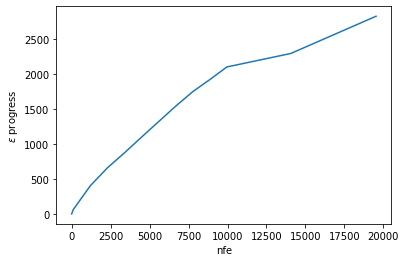

In [10]:
results, convergence = results_epsilon_0_1
convergence = pd.DataFrame(convergence)
plt.plot(convergence.nfe, convergence.epsilon_progress)
plt.ylabel('$\epsilon$ progress')
plt.xlabel('nfe')
plt.show()

## Show tradeoffs in the resulting optimal policies
The algorithm found 2011 solutions. It is important to note that convergence has not been reached. Due to limitations in computing power and time restriction this part of the code was not able to run until full convergence was attained. This should be taken into consideration when discussing the results, as results can be contested and disputed based on this. However, as this is the first  part of the scenario analysis, which precedes the multi-scenario MORDM, full convergence is not necessary as the scenarios which will 'break' the optimal policies are still valid

In [43]:
fig = px.parallel_coordinates(results_epsilon_0_1[0].iloc[:, 31::], color=results_epsilon_0_1[0].index)
fig.update_layout(showlegend=False)
fig.show()

## Re-Evaluate under deep uncertainty
For evaluating the promising policies under deep uncertainty, we set a hard limit on one expected casualties below 0.001 and expected damages below €100.000. 

In [12]:
results_subset = results[
    (results["Expected Number of Deaths"] < 0.001) &
    (results["Gelderland Expected Annual Damage"] < 100000) &
    (results["Overijssel Expected Annual Damage"] < 100000)]

We further use the remaining policies to test them under deep uncertainty by running the policies for 1000 scenarios each. 

In [13]:
policies = results_subset.iloc[:,0:31]
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [14]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 6 policies * 1 model(s) = 6000 experiments
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 5400 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [15]:
#Save results
save_results(results, "../results/DeepUncertaintyPolicies_Holistic_PF8_10000scenarios.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\DeepUncertaintyPolicies_Holistic_PF8_10000scenarios.tar.gz


### Signal-to-noise Ratio
To find the most robust policy, we rate the different policies by calculating the signal-to-noise ratio. 

In [16]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [17]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs
1230,1.242936e+15,4.021222e+13,1.126944e-05,1179.590956,0.000000,0.0,518501.507946
1542,2.073503e+11,8.824753e+12,1.115220e-06,0.000000,66.329470,0.0,9356.535459
1811,1.132058e+14,4.053404e+12,1.714186e-06,498.556132,66.931453,0.0,35961.335218
777,6.329201e+14,8.991776e+13,8.771349e-06,1188.852668,13.170693,0.0,642534.461308
862,1.516791e+11,7.742505e+11,1.805932e-08,1075.411366,80.984819,0.0,4422.390573
902,7.006770e+13,3.229900e+11,1.031420e-06,1084.718975,0.000000,0.0,16659.658353


In [18]:
fig = px.parallel_coordinates(scores, labels= 
{"Gelderland Yearly Damage": 'Gelderland Expected Annual Damage', "Overijssel Yearly Damage":'Overijssel Expected Annual Damage', "Expected Deaths":'Expected Number of Deaths', "Gelderland Dike Costs":'Gelderland Dike Cost',
 "Overijssel Dike Costs":'Overijssel Dike Cost', "RfR Costs":'Room for River Investment Costs', "Evacuation Cost":'Evacuation Costs'})
fig.show()


### Maximum Regret
Another robustness criterion is the maximum regret measure. We again calculate this measure for every policy selected

In [19]:
def calculate_regret(data, best):
    return np.abs(best-data)


overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    data = data.pivot(index='scenario', columns='policy')
    
    data.columns = data.columns.get_level_values(1)
    
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

The heat map highlights that to perform well on expected damages, as seen with policy 777 for Overijssel, there have to be high dike investment costs and RfR investment costs. There is a clear trade-off between costs and safety in terms of expected annual damages and deaths.

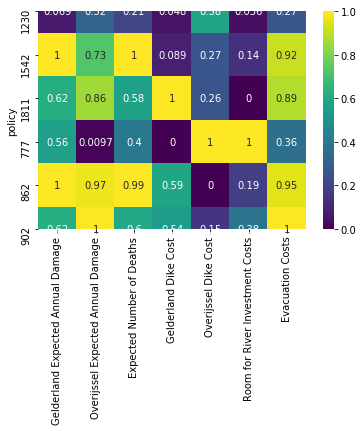

In [20]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [21]:
fig = px.parallel_coordinates(max_regret, labels = {"Gelderland Yearly Damage": 'Gelderland Expected Annual Damage', "Overijssel Yearly Damage":'Overijssel Expected Annual Damage', "Expected Deaths":'Expected Number of Deaths', "Gelderland Dike Costs":'Gelderland Dike Cost',
 "Overijssel Dike Costs":'Overijssel Dike Cost', "RfR Costs":'Room for River Investment Costs', "Evacuation Cost":'Evacuation Costs'})
fig.show()

In [22]:
max_regret

,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs
policy,,,,,,,
1230,9.236219e+07,9.853221e+07,0.019975,1.942322e+07,2.663844e+08,4.020000e+07,4893.405606
1542,1.334609e+09,2.262005e+08,0.094823,3.565485e+07,1.229380e+08,1.519000e+08,16497.871166
1811,8.267738e+08,2.656997e+08,0.054677,4.021088e+08,1.178882e+08,0.000000e+00,15938.832494
777,7.481117e+08,3.022357e+06,0.037943,0.000000e+00,4.583823e+08,1.103300e+09,6491.048101
862,1.328595e+09,3.020429e+08,0.094261,2.379037e+08,0.000000e+00,2.058000e+08,17184.231665
902,8.267738e+08,3.101858e+08,0.056704,2.183842e+08,6.921257e+07,4.236000e+08,18002.884716


In [23]:
outcomes.keys()

dict_keys(['Gelderland Expected Annual Damage', 'Overijssel Expected Annual Damage', 'Expected Number of Deaths', 'Gelderland Dike Cost', 'Overijssel Dike Cost', 'Room for River Investment Costs', 'Evacuation Costs'])

## Scenario Discovery
We perform Scenario Discovery using the PRIM-algorithm to discover such scenarios in which the robust policies fail. We focus on such scenarios where death and damages occur.

In [24]:
x = experiments.iloc[:,0:19]
# Check Overijssel!
outcomes["selection"] = outcomes["Gelderland Expected Annual Damage"] + outcomes['Overijssel Expected Annual Damage'] + outcomes["Expected Number of Deaths"]

y =  outcomes["selection"] > 0 
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] 6000 points remaining, containing 1079 cases of interest
[MainProcess/INFO] mean: 0.5062893081761006, mass: 0.053, coverage: 0.14921223354958293, density: 0.5062893081761006 restricted_dimensions: 9


In [25]:
box.inspect_tradeoff()


alt.VConcatChart(...)

We select box 29, as it shows a good mixture between coverage and density

In [26]:
box.inspect(len(box.peeling_trajectory)-1)


coverage    0.149212
density     0.506289
id                29
mass           0.053
mean        0.506289
res_dim            9
Name: 29, dtype: object

                          box 29                   \
                             min              max   
A.5_pfail            0.000398194         0.522812   
A.4_pfail            0.000300828            0.903   
A.2_pfail            0.000255567         0.975784   
A.3_Bmax                 30.0676          315.507   
A.3_Brate                 {10.0}           {10.0}   
A.5_Brate            {10.0, 1.0}      {10.0, 1.0}   
A.2_Bmax                 76.9821          349.908   
A.5_Bmax                 79.2482          349.778   
discount rate 1  {1.5, 2.5, 3.5}  {1.5, 2.5, 3.5}   

                                                 
                                      qp values  
A.5_pfail        [-1.0, 1.1564180902367974e-07]  
A.4_pfail           [-1.0, 0.13389511558088119]  
A.2_pfail            [-1.0, 0.2134260474156317]  
A.3_Bmax       

In [27]:
box.select(len(box.peeling_trajectory)-1)
scens_in_box = experiments.iloc[box.yi]
outcomes_in_box = {k:v[box.yi] for k,v in outcomes.items()}
#Save results
save_results((scens_in_box, outcomes_in_box), '../results/mordm_holistic_PF8.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\mordm_holistic_PF8.tar.gz


# Multi-Scenario MORDM
Based on the results of scenario discovery, we now continue to select three of such scenarios based on the worst outcomes in terms of casualties, damages and total costs. We will take each of these scenarios as a reference scenario to run an optimization algorithm for the levers to choose. 

In [28]:
mordm_results = load_results('../results/mordm_holistic_PF8.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\mordm_holistic_PF8.tar.gz


In [29]:
scens_in_box = mordm_results[0]
outcomes_in_box = mordm_results[1]

In [30]:
#Load results
#mordm_results = load_results('../results/mordm_holistic_52.tar.gz')
results_df = pd.concat([pd.DataFrame(scens_in_box).reset_index(drop=True), pd.DataFrame(outcomes_in_box)], axis = 1)

In [31]:
results_df.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,policy,model,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs,selection
0,1.0,110.819035,10.0,0.185466,114.569372,1.0,0.000256,84.871136,10,0.473053,...,777,dikesnet,1.751178e+07,0.000000e+00,0.002321,2.493205e+09,2.209676e+08,182600000.0,1114.371266,1.751178e+07
1,53.0,145.433151,10.0,0.137399,228.916020,10.0,0.359768,65.945206,10,0.198418,...,777,dikesnet,0.000000e+00,2.899810e+07,0.003278,2.493205e+09,2.209676e+08,182600000.0,1815.150008,2.899810e+07
2,71.0,321.732749,1.0,0.208075,202.404804,10.0,0.163844,122.330593,10,0.604073,...,777,dikesnet,0.000000e+00,3.497452e+07,0.003375,2.493205e+09,2.209676e+08,182600000.0,1863.801358,3.497452e+07
3,110.0,88.426824,1.0,0.248175,338.513416,1.0,0.192359,42.637227,10,0.911970,...,777,dikesnet,0.000000e+00,3.310204e+07,0.003456,2.493205e+09,2.209676e+08,182600000.0,1933.338239,3.310204e+07
4,54.0,318.553858,1.0,0.245652,159.031984,10.0,0.429925,243.383374,10,0.316990,...,777,dikesnet,0.000000e+00,2.791697e+07,0.003116,2.493205e+09,2.209676e+08,182600000.0,1764.620822,2.791697e+07


In [32]:
#Sum up Deaths and Damages

#results_df["Deaths Aggregated"] = results_df["A1_2 Aggr Expected Number of Deaths"] + results_df["A3 Aggr Expected Number of Deaths"]

#Overijssel fix
results_df["Damages Aggregated"] = results_df["Gelderland Expected Annual Damage"] + results_df["Overijssel Expected Annual Damage"]

In [33]:
# Create the three reference case scenario instances

i = 0
j = 0

# Ensure that the three reference scenarios are different
if results_df.sort_values(["Evacuation Costs"]).tail(1).index[0] == results_df.sort_values(["Expected Number of Deaths"]).tail(1).index[0]:
    i =+ 1
if results_df.sort_values(["Expected Number of Deaths"]).tail(1+i).index[0] == results_df.sort_values(["Damages Aggregated"]).tail(1+i).index[0]:
    j =+ 1

scenario_indices = [results_df.sort_values(["Expected Number of Deaths"]).tail(1).index[0],
                    results_df.sort_values(["Evacuation Costs"]).tail(1+i).index[0],
                    results_df.sort_values(["Damages Aggregated"]).tail(1+i+j).index[0]]
selected = results_df.iloc[scenario_indices, 0:19]

In [34]:
scenario_indices

[205, 188, 46]

In [35]:
ref_scenario_deaths_experiments =  results_df.iloc[scenario_indices[0],0:52]
ref_scenario_deaths_outcomes = results_df.iloc[scenario_indices[0],53::]

In [36]:
# Reference scenario for SOBOL analysis
# This scenario will be used to perform a sensitivity analysis
save_results([pd.DataFrame(ref_scenario_deaths_experiments).T, pd.DataFrame(ref_scenario_deaths_outcomes).T], "../results/Holistic_msMORDM_WorstCaseDeaths_PF8.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\Holistic_msMORDM_WorstCaseDeaths_PF8.tar.gz


In [37]:
#Create the three reference case scenario instances
scenarios_mordm = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [33]:
def optimize(scenario, nfe, model, converge_metrics, epsilons):

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=n_nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence


results = []

for scenario in scenarios_mordm:
    convergence_metrics = [EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    results.append(optimize(scenario, 2e4, dike_model, convergence_metrics, epsilons))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/20000 nfe
[MainProcess/INFO] generation 5: 500/20000 nfe
[MainProcess/INFO] generation 10: 997/20000 nfe
[MainProcess/INFO] generation 15: 1496/20000 nfe
[MainProcess/INFO] generation 20: 1992/20000 nfe
[MainProcess/INFO] generation 25: 2492/20000 nfe
[MainProcess/INFO] generation 30: 2991/20000 nfe
[MainProcess/INFO] generation 35: 3489/20000 nfe
[MainProcess/INFO] generation 40: 3984/20000 nfe
[MainProcess/INFO] generation 45: 4483/20000 nfe
[MainProcess/INFO] generation 50: 4982/20000 nfe
[MainProcess/INFO] generation 55: 5478/20000 nfe
[MainProcess/INFO] generation 60: 5978/20000 nfe
[MainProcess/INFO] generation 65: 6477/20000 nfe
[MainProcess/INFO] generation 70: 6976/20000 nfe
[MainProcess/INFO] generation 75: 7474/20000 nfe
[MainProcess/INFO] generation 80: 7974/20000 nfe
[MainProcess/INFO] generation 85: 8473/20000 nfe
[MainProcess/INFO] generation 90: 8970/20000 nfe
[MainProcess/INFO] generation 95: 9469/20000

In [37]:
# save_results(results[0], "../results/ms_mordm_PF8_"+str(n_nfe)+"nfe_"+"_reference1.tar.gz")
# save_results(results[1], "../results/ms_mordm_PF8_"+str(n_nfe)+"nfe_"+"_reference2.tar.gz")
# save_results(results[2], "../results/ms_mordm_PF8_"+str(n_nfe)+"nfe_"+"_reference3.tar.gz")

In [35]:
# Original runs saved

# save_results(results[0], "../results/ms_mordm_PF8_"+str(n_nfe)+"nfe_"+"_reference1.tar.gz")
# save_results(results[1], "../results/ms_mordm_PF8_"+str(n_nfe)+"nfe_"+"_reference2.tar.gz")
# save_results(results[2], "../results/ms_mordm_PF8_"+str(n_nfe)+"nfe_"+"_reference3.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\ms_mordm_PF8_20000nfe__reference1.tar.gz
[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\ms_mordm_PF8_20000nfe__reference2.tar.gz
[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\ms_mordm_PF8_20000nfe__reference3.tar.gz


In [70]:
results_ref1 = load_results("../results/ms_mordm_PF8_"+str(n_nfe)+"nfe_"+"_reference1.tar.gz")
results_ref2 = load_results("../results/ms_mordm_PF8_"+str(n_nfe)+"nfe_"+"_reference2.tar.gz")
results_ref3 = load_results("../results/ms_mordm_PF8_"+str(n_nfe)+"nfe_"+"_reference3.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\ms_mordm_PF8_20000nfe__reference1.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\ms_mordm_PF8_20000nfe__reference2.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\ms_mordm_PF8_20000nfe__reference3.tar.gz


For these scenarios it is once again clear that ull convergence has not been reached. Running this section for 20,000 nfes took over 12 hours to run. Therefore, due to time constraints, we were not able to re-run this section for a higher number of nfe's. This means that the policies found form this, while optimised for these scenarios, will not be the optimal policies in the whole policy-sphere. This means that knowledge can be disputed and the analysis should be continued with a higher number of nfe's to reduce the uncertainty of this aspect.

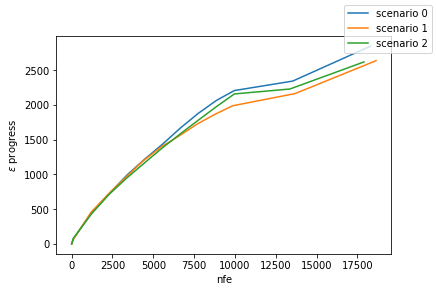

In [36]:
fig, (ax2) = plt.subplots(ncols=1)
for i, (_, convergence) in enumerate(results):
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

In [71]:
#ms_results_df = pd.concat([results[0][0],results[1][0], results[2][0]], axis=0)
ms_results_df = pd.concat([results_ref1[0],results_ref2[0],results_ref3[0]],axis = 0)

In [72]:
ms_results_df = ms_results_df.reset_index(drop=True)

In [73]:
ms_results_df

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs
0,1,0,1,0,0,1,0,1,1,0,...,10,0,10,1.912842e+07,0.000000e+00,0.024028,2.449754e+09,6.979273e+08,4.484000e+08,0.000000
1,1,0,1,1,0,1,1,1,0,1,...,0,1,0,7.685420e+06,6.551959e+07,0.010622,2.650930e+09,1.251861e+08,1.420800e+09,4017.458055
2,0,1,1,1,1,1,0,1,0,1,...,0,0,2,0.000000e+00,7.256951e+07,0.009547,2.933679e+09,1.378911e+08,1.351800e+09,3634.256626
3,0,0,1,0,0,0,1,0,1,0,...,1,3,0,1.208207e+08,4.428563e+07,0.156925,1.949862e+09,2.821294e+08,4.021000e+08,0.000000
4,1,1,1,0,0,1,0,0,1,0,...,0,8,4,0.000000e+00,1.179574e+08,0.015088,2.140610e+09,4.606705e+08,5.023000e+08,9253.417734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5374,1,0,0,0,1,1,0,0,1,1,...,2,8,0,3.797978e+07,3.486052e+06,0.056402,1.796725e+09,3.970531e+08,1.049400e+09,0.000000
5375,1,0,1,0,1,1,1,1,0,0,...,7,6,0,2.392760e+07,0.000000e+00,0.023883,1.308587e+09,4.757311e+08,6.662000e+08,0.000000
5376,0,0,0,0,1,1,0,1,0,0,...,7,1,7,1.295283e+08,0.000000e+00,0.049180,1.987780e+09,6.684607e+08,4.663000e+08,4159.542384
5377,0,0,1,0,0,0,1,0,0,0,...,0,3,0,5.475039e+08,7.427704e+07,0.058597,1.994727e+09,1.517576e+08,1.153000e+08,12463.116268


In [68]:
fig = px.parallel_coordinates(ms_results_df.iloc[:,31::], labels= {"Gelderland Yearly Damage": 'Gelderland Expected Annual Damage', "Overijssel Yearly Damage":'Overijssel Expected Annual Damage', "Expected Deaths":'Expected Number of Deaths', "Gelderland Dike Costs":'Gelderland Dike Cost',
 "Overijssel Dike Costs":'Overijssel Dike Cost', "RfR Costs":'Room for River Investment Costs', "Evacuation Cost":'Evacuation Costs'}, color=ms_results_df.index)
fig.show()

# Selection of promising policies

We again select from the solutions found only these which lead to no expected deaths and no expected damage.



In [74]:
ms_results_subset = ms_results_df[
    ((ms_results_df["Gelderland Expected Annual Damage"] + ms_results_df["Overijssel Expected Annual Damage"]) == 0) &
    ((ms_results_df["Expected Number of Deaths"]  == 0))]

In [75]:
ms_results_subset

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs
316,1,0,1,1,0,1,1,0,0,1,...,7,0,0,0.0,0.0,0.0,1.650707e+09,2.209676e+08,1.012800e+09,0.0
392,1,0,1,1,1,1,1,1,1,1,...,7,0,0,0.0,0.0,0.0,1.598046e+09,2.209676e+08,1.669300e+09,0.0
422,1,0,1,1,1,1,1,1,1,1,...,6,1,0,0.0,0.0,0.0,1.593155e+09,3.545158e+08,1.413200e+09,0.0
534,0,1,1,0,0,1,1,1,0,0,...,6,2,0,0.0,0.0,0.0,2.355673e+09,3.700587e+08,8.257000e+08,0.0
770,0,1,0,0,0,1,1,1,1,1,...,9,3,0,0.0,0.0,0.0,3.134667e+09,4.709136e+08,5.157000e+08,0.0
773,0,1,0,0,1,0,1,1,0,1,...,5,2,0,0.0,0.0,0.0,3.673856e+09,3.464999e+08,8.623000e+08,0.0
775,1,1,0,0,0,0,0,1,1,0,...,10,7,2,0.0,0.0,0.0,3.623901e+09,8.442128e+08,2.306000e+08,0.0
786,1,0,0,0,0,1,0,1,1,0,...,7,1,0,0.0,0.0,0.0,3.042386e+09,3.793482e+08,6.062000e+08,0.0
787,1,1,1,1,0,1,0,1,1,0,...,5,0,0,0.0,0.0,0.0,2.652382e+09,1.833834e+08,1.249300e+09,0.0
797,0,0,0,0,1,1,1,0,0,1,...,9,1,3,0.0,0.0,0.0,2.709184e+09,6.473200e+08,5.875000e+08,0.0


In [76]:
ms_results_subset["Total Costs"] = ms_results_subset["Gelderland Dike Cost"] + ms_results_subset["Overijssel Dike Cost"] + ms_results_subset["Room for River Investment Costs"]

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [77]:
#Select only the 10 cheapest policies in terms of total costs. 
ms_results_subset_10 = ms_results_subset.sort_values("Total Costs").head(10)
ms_results_subset_10

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs,Total Costs
4166,0,1,0,0,1,0,0,1,0,0,...,0,0,0.0,0.0,0.0,2.059215e+09,2.209676e+08,3.331000e+08,0.0,2.613283e+09
4500,1,0,1,0,0,1,0,1,0,0,...,4,0,0.0,0.0,0.0,1.462841e+09,4.913833e+08,6.738000e+08,0.0,2.628025e+09
2035,0,1,1,0,0,0,0,0,0,1,...,2,7,0.0,0.0,0.0,1.769590e+09,6.944139e+08,2.904000e+08,0.0,2.754404e+09
3964,1,1,1,0,0,1,0,1,0,0,...,0,2,0.0,0.0,0.0,1.868319e+09,3.954222e+08,5.023000e+08,0.0,2.766041e+09
1088,1,1,0,0,1,0,1,0,0,1,...,4,0,0.0,0.0,0.0,1.554525e+09,4.321048e+08,7.950000e+08,0.0,2.781630e+09
316,1,0,1,1,0,1,1,0,0,1,...,0,0,0.0,0.0,0.0,1.650707e+09,2.209676e+08,1.012800e+09,0.0,2.884475e+09
4111,1,1,0,0,1,0,0,1,1,0,...,0,0,0.0,0.0,0.0,2.186021e+09,2.013684e+08,5.696000e+08,0.0,2.956990e+09
1601,1,1,0,0,1,0,0,1,0,0,...,3,4,0.0,0.0,0.0,1.957427e+09,7.206756e+08,4.177000e+08,0.0,3.095802e+09
2883,1,1,1,0,1,1,0,1,0,1,...,3,0,0.0,0.0,0.0,1.814422e+09,3.870224e+08,9.625000e+08,0.0,3.163944e+09
3574,1,1,0,0,1,0,0,1,1,0,...,5,0,0.0,0.0,0.0,1.923128e+09,4.257120e+08,8.257000e+08,0.0,3.174540e+09


In [79]:
ms_policies = ms_results_subset_10.iloc[:,0:31]
ms_policies_to_evaluate = []

for i, policy in ms_policies.iterrows():
    ms_policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))


In [20]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, ms_policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [21]:
#Save results
save_results(results, "../results/Multi_Scenario_DeepUncertainty"+str(len(ms_policies_to_evaluate))+"policies_"+str(n_scenarios)+"scenarios_"+"Holistic_PF8"+".tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\Multi_Scenario_DeepUncertainty10policies_1000scenarios_Holistic_PF8.tar.gz


In [80]:
#load_results
reevaluation_results = load_results("../results/Multi_Scenario_DeepUncertainty"+str(len(ms_policies_to_evaluate))+"policies_"+str(n_scenarios)+"scenarios_"+"Holistic_PF8"+".tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\Multi_Scenario_DeepUncertainty10policies_1000scenarios_Holistic_PF8.tar.gz


# Robustness Assessment

## Domain Criterion

In [81]:
reevaluation_results[1].keys()

dict_keys(['Gelderland Expected Annual Damage', 'Overijssel Expected Annual Damage', 'Expected Number of Deaths', 'Gelderland Dike Cost', 'Overijssel Dike Cost', 'Room for River Investment Costs', 'Evacuation Costs'])

In [82]:
experiments, outcomes = reevaluation_results
reevaluation_df = pd.concat([pd.DataFrame(experiments), pd.DataFrame(outcomes)], axis = 1)

domain_criterion = pd.DataFrame(columns=["policy", "Gelderland Damage", "Overijssel Damage", "Total Deaths", "Evacuation Costs"])

for policy in reevaluation_df["policy"].unique():
    policy_subset = reevaluation_df[reevaluation_df["policy"] == policy]

    gelderland_damage_dc = len(policy_subset["Gelderland Expected Annual Damage"][policy_subset["Gelderland Expected Annual Damage"] > 0])/1000
    overijssel_damage_dc = len(policy_subset["Overijssel Expected Annual Damage"][policy_subset["Overijssel Expected Annual Damage"] > 0])/1000
    total_deaths_dc = len(policy_subset["Expected Number of Deaths"][policy_subset["Expected Number of Deaths"] > 0])/1000
    evac_costs_dc = len(policy_subset["Evacuation Costs"][policy_subset["Evacuation Costs"] > 0])/1000

    domain_criterion = domain_criterion.append(pd.DataFrame({"policy": [policy],"Gelderland Damage": [gelderland_damage_dc],
                                                             "Overijssel Damage" : [overijssel_damage_dc], "Total Deaths" : [total_deaths_dc],
                                                             "Evacuation Costs" : [evac_costs_dc]}) )

domain_criterion = domain_criterion.reset_index(drop=True)

In [83]:
policy_costs = reevaluation_df.groupby("policy").mean()
policy_costs["Total Costs"] = policy_costs["Gelderland Dike Cost"] + policy_costs["Overijssel Dike Cost"] +  policy_costs["Room for River Investment Costs"]
domain_criterion_costs = pd.merge(domain_criterion, policy_costs[["Total Costs"]], how="left", on="policy")


In [84]:
domain_criterion_costs

,policy,Gelderland Damage,Overijssel Damage,Total Deaths,Evacuation Costs,Total Costs
0,4166,0.222,0.273,0.431,0.431,2.613283e+09
1,4500,0.165,0.136,0.280,0.280,2.628025e+09
2,2035,0.285,0.197,0.444,0.444,2.754404e+09
3,3964,0.222,0.261,0.431,0.431,2.766041e+09
4,1088,0.140,0.140,0.268,0.000,2.781630e+09
5,316,0.254,0.244,0.444,0.444,2.884475e+09
6,4111,0.119,0.229,0.317,0.317,2.956990e+09
7,1601,0.170,0.218,0.357,0.357,3.095802e+09
8,2883,0.256,0.087,0.329,0.329,3.163944e+09
9,3574,0.357,0.170,0.493,0.000,3.174540e+09


In [85]:
fig = px.parallel_coordinates(domain_criterion_costs, color = "policy", dimensions=["Gelderland Damage", "Overijssel Damage",
                                                                                    "Total Deaths",  "Total Costs"])
fig.show()

# Scenario Discovery: PRIM

We perform Scenario Discovery using the PRIM-algorithm to discover such scenarios in which the robust policies fail. We focus on such scenarios where death and damages occur.

In [118]:
outcomes["condition"] = outcomes["Gelderland Expected Annual Damage"] + outcomes["Overijssel Expected Annual Damage"] + outcomes["Expected Number of Deaths"]
x = experiments.iloc[:,0:19]
y = outcomes["condition"] > 0
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()


[MainProcess/INFO] 10000 points remaining, containing 3794 cases of interest
[MainProcess/INFO] mean: 0.6987179487179487, mass: 0.078, coverage: 0.14364786505007907, density: 0.6987179487179487 restricted_dimensions: 11


In [119]:
box.inspect_tradeoff()

alt.VConcatChart(...)

In [120]:
n_box = 37
box.inspect(n_box)

coverage    0.143648
density     0.698718
id                37
mass           0.078
mean        0.698718
res_dim           11
Name: 37, dtype: object

                                  box 37                   \
                                     min              max   
A.2_pfail                    0.000551685         0.735912   
A.4_pfail                    0.000835095         0.732939   
A.5_pfail                    0.000872177          0.73013   
A.3_pfail                    0.000888457         0.763269   
A.3_Bmax                         30.2772          313.875   
discount rate 0          {2.5, 3.5, 4.5}  {2.5, 3.5, 4.5}   
A.2_Brate                    {1.5, 10.0}      {1.5, 10.0}   
A.1_Bmax                         79.7678          335.715   
A.2_Bmax                         61.3333           349.81   
A.1_pfail                      0.0544636         0.999429   
A.0_ID flood wave shape              7.5            125.5   

                                                       

In [122]:
box.select(n_box)
scens_in_box = experiments.iloc[box.yi]
outcomes_in_box = {k:v[box.yi] for k,v in outcomes.items()}

In [123]:
results_df_final = pd.concat([pd.DataFrame(scens_in_box).reset_index(drop=True), 
                              pd.DataFrame(outcomes_in_box)], axis = 1)

In [132]:
results_df_final

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,policy,model,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs,condition
0,86.0,84.456869,10.0,0.361577,243.617357,10.0,0.258930,114.685420,1.5,0.046368,...,4166,dikesnet,1.821091e+07,0.000000e+00,0.005316,2.059215e+09,2.209676e+08,333100000.0,1073.995185,1.821091e+07
1,16.0,277.040522,1.5,0.504558,194.900625,1.5,0.156012,216.066531,10.0,0.020716,...,4166,dikesnet,3.309054e+07,0.000000e+00,0.010691,2.059215e+09,2.209676e+08,333100000.0,2172.288315,3.309054e+07
2,12.0,212.472648,1.5,0.795590,251.027073,10.0,0.517993,69.027166,1.5,0.048311,...,4166,dikesnet,2.894024e+07,0.000000e+00,0.005345,2.059215e+09,2.209676e+08,333100000.0,1074.535518,2.894024e+07
3,120.0,270.810268,1.5,0.584377,230.359704,10.0,0.183041,286.095647,1.5,0.667367,...,4166,dikesnet,0.000000e+00,0.000000e+00,0.000000,2.059215e+09,2.209676e+08,333100000.0,0.000000,0.000000e+00
4,118.0,131.091866,10.0,0.973010,283.674340,1.5,0.508912,123.936621,10.0,0.616531,...,4166,dikesnet,0.000000e+00,1.708270e+06,0.000147,2.059215e+09,2.209676e+08,333100000.0,129.226912,1.708270e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,71.0,172.335750,1.0,0.680537,68.443183,10.0,0.119512,241.256148,10.0,0.482541,...,3574,dikesnet,0.000000e+00,1.490157e+06,0.002074,1.923128e+09,4.257120e+08,825700000.0,0.000000,1.490157e+06
776,105.0,114.843862,10.0,0.833807,185.603853,1.5,0.593812,78.276898,1.0,0.662494,...,3574,dikesnet,0.000000e+00,1.592766e+06,0.002224,1.923128e+09,4.257120e+08,825700000.0,0.000000,1.592766e+06
777,115.0,147.511509,10.0,0.211664,213.911548,1.5,0.634395,156.730010,1.0,0.051254,...,3574,dikesnet,3.115332e+07,0.000000e+00,0.080753,1.923128e+09,4.257120e+08,825700000.0,0.000000,3.115332e+07
778,12.0,252.936178,1.0,0.712051,302.946929,1.5,0.429039,122.107520,1.5,0.029019,...,3574,dikesnet,5.999766e+07,0.000000e+00,0.120934,1.923128e+09,4.257120e+08,825700000.0,0.000000,5.999766e+07


In [126]:
results_df_final['policy'].unique()

[4166, 4500, 2035, 3964, 1088, 316, 4111, 1601, 2883, 3574]
Categories (10, int64): [4166, 4500, 2035, 3964, ..., 4111, 1601, 2883, 3574]

In [128]:
outcomes_in_box.keys()

dict_keys(['Gelderland Expected Annual Damage', 'Overijssel Expected Annual Damage', 'Expected Number of Deaths', 'Gelderland Dike Cost', 'Overijssel Dike Cost', 'Room for River Investment Costs', 'Evacuation Costs', 'condition'])

In [153]:
results_df_final_interest = results_df_final[results_df_final['Gelderland Expected Annual Damage'] == 0]
                                           
results_df_final_interest = results_df_final_interest[results_df_final_interest['Overijssel Expected Annual Damage'] == 0]
                                                   
results_df_final_interest = results_df_final_interest[results_df_final_interest['Expected Number of Deaths'] == 0]
                                                  
results_df_final_interest

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,policy,model,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs,condition
3,120.0,270.810268,1.5,0.584377,230.359704,10.0,0.183041,286.095647,1.5,0.667367,...,4166,dikesnet,0.0,0.0,0.0,2.059215e+09,2.209676e+08,333100000.0,0.0,0.0
9,58.0,286.300305,1.0,0.432625,121.921997,1.5,0.465425,96.731864,10.0,0.236658,...,4166,dikesnet,0.0,0.0,0.0,2.059215e+09,2.209676e+08,333100000.0,0.0,0.0
14,57.0,259.473197,1.0,0.508004,162.460920,10.0,0.437000,246.283144,1.0,0.278871,...,4166,dikesnet,0.0,0.0,0.0,2.059215e+09,2.209676e+08,333100000.0,0.0,0.0
18,65.0,148.669445,1.0,0.673987,249.449183,10.0,0.200644,131.885825,1.0,0.134066,...,4166,dikesnet,0.0,0.0,0.0,2.059215e+09,2.209676e+08,333100000.0,0.0,0.0
19,41.0,123.153505,10.0,0.827192,133.034865,10.0,0.606731,153.329213,1.5,0.240529,...,4166,dikesnet,0.0,0.0,0.0,2.059215e+09,2.209676e+08,333100000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,116.0,251.497399,10.0,0.659303,213.147605,10.0,0.530285,197.107101,1.0,0.499381,...,3574,dikesnet,0.0,0.0,0.0,1.923128e+09,4.257120e+08,825700000.0,0.0,0.0
762,71.0,186.807189,10.0,0.372066,242.235213,1.5,0.144734,158.133446,10.0,0.408676,...,3574,dikesnet,0.0,0.0,0.0,1.923128e+09,4.257120e+08,825700000.0,0.0,0.0
765,41.0,120.899314,10.0,0.677420,234.143111,1.5,0.182752,262.101999,10.0,0.622290,...,3574,dikesnet,0.0,0.0,0.0,1.923128e+09,4.257120e+08,825700000.0,0.0,0.0
768,72.0,265.339285,1.0,0.662936,281.263755,10.0,0.178377,312.113172,1.0,0.530439,...,3574,dikesnet,0.0,0.0,0.0,1.923128e+09,4.257120e+08,825700000.0,0.0,0.0


In [168]:
# Based on the domain criterion and the PRIM results we will determine which policies are the most suitable.

results_count = {k:len(results_df_final_interest[results_df_final_interest['policy']== k]) for k in results_df_final['policy'].unique()}

results_count



{4166: 16,
 4500: 30,
 2035: 18,
 3964: 16,
 1088: 34,
 316: 19,
 4111: 28,
 1601: 26,
 2883: 33,
 3574: 15}

Based on solutions from the Scenario Discovery through PRIM, the policies which in most scenarios show no deaths nor damage to either province are policies: 1088 (34), 2883 (33), 4500 (30), 4111 (28) and 1601 (26)

We will combine these with the domain criterion to choose 3 suitable policies.

Of these policies, policy 4500 has the lowest total cost, ranks second in terms of deaths and has a relatively low
Scoring: 
<br>Lowest damage (Gelderland) : 4111
<br>Lowest Damage Overijssel: 2883
<br>Lowest Total Deaths: 1088
<br>Lowest Total Costs: 4500

__Policy 4500__ has the *lowest cost*, *second lowest deaths* and does well in terms of *damage* for Overijssel and Gelderland. This makes it the most suitable policy following this analysis. The other policy which should be considered from a holistic point is *1088*. Other policies are either less effective or a lot more expensive.

In [182]:
chosen_PRIM = [1088, 2883, 4500, 4111, 1601]

domain_chosen = domain_criterion_costs[domain_criterion_costs['policy'].isin(chosen_PRIM)]

In [183]:
domain_chosen

,policy,Gelderland Damage,Overijssel Damage,Total Deaths,Evacuation Costs,Total Costs
1,4500,0.165,0.136,0.280,0.280,2.628025e+09
4,1088,0.140,0.140,0.268,0.000,2.781630e+09
6,4111,0.119,0.229,0.317,0.317,2.956990e+09
7,1601,0.170,0.218,0.357,0.357,3.095802e+09
8,2883,0.256,0.087,0.329,0.329,3.163944e+09


In [184]:
fig = px.parallel_coordinates(domain_chosen, color = "policy", dimensions=["Gelderland Damage", "Overijssel Damage",
                                                                                    "Total Deaths",  "Total Costs"])
fig.show()

In [200]:
policy_4500 = pd.DataFrame(results_df_final[results_df_final['policy']==4500].iloc[0,19::]).T.reset_index(drop=True)

In [201]:
policy_1088 = pd.DataFrame(results_df_final[results_df_final['policy']==1088].iloc[0,19::]).T.reset_index(drop=True)

In [202]:
chosen_policies_Holistic = pd.concat([policy_4500, policy_1088],axis = 0)
chosen_policies_Holistic

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,policy,model,Gelderland Expected Annual Damage,Overijssel Expected Annual Damage,Expected Number of Deaths,Gelderland Dike Cost,Overijssel Dike Cost,Room for River Investment Costs,Evacuation Costs,condition
0,1,0,1,0,0,1,0,1,0,0,...,4500,dikesnet,2.59212e+06,0,0.00084544,1.46284e+09,4.91383e+08,6.738e+08,168.471,2.59212e+06
0,1,1,0,0,1,0,1,0,0,1,...,1088,dikesnet,3.44476e+06,0,0.00816455,1.55453e+09,4.32105e+08,7.95e+08,0,3.44476e+06


In [198]:
# Write these results to a CSV file
chosen_policies_Holistic.to_csv('../results/mordm_holistic_PF8_policies.csv')

In [86]:
chosen_policies_Holistic = pd.read_csv('../results/mordm_holistic_PF8_policies.csv')

In [87]:
fig = px.parallel_coordinates(chosen_policies_Holistic.iloc[:,1:17], labels = {}, color = chosen_policies_Holistic["policy"])
fig.show()

In [88]:
fig = px.parallel_coordinates(chosen_policies_Holistic.iloc[:,18:34], labels = {}, color = chosen_policies_Holistic["policy"])
fig.show()

In [90]:
fig = px.parallel_coordinates(chosen_policies_Holistic.iloc[:,35:42], labels = {}, color = chosen_policies_Holistic["policy"])
fig.show()